In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

#Set constants
RANDOM_SEED = 42

In [2]:
# Import data from csv file
data = pd.read_csv("../../machine_learning/siren_data_train.csv", sep=",")

# Create X and y
features = ["near_fid", "near_x", "near_y", "near_angle", "building", "xcoor", "ycoor", "noise", "in_vehicle", "asleep", "no_windows", "age"]
X = data[features]
y = data[["heard"]]

# Create training data and held-out test data
X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, test_size=None, random_state=RANDOM_SEED, shuffle=True)


In [3]:
# Learn a decision tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

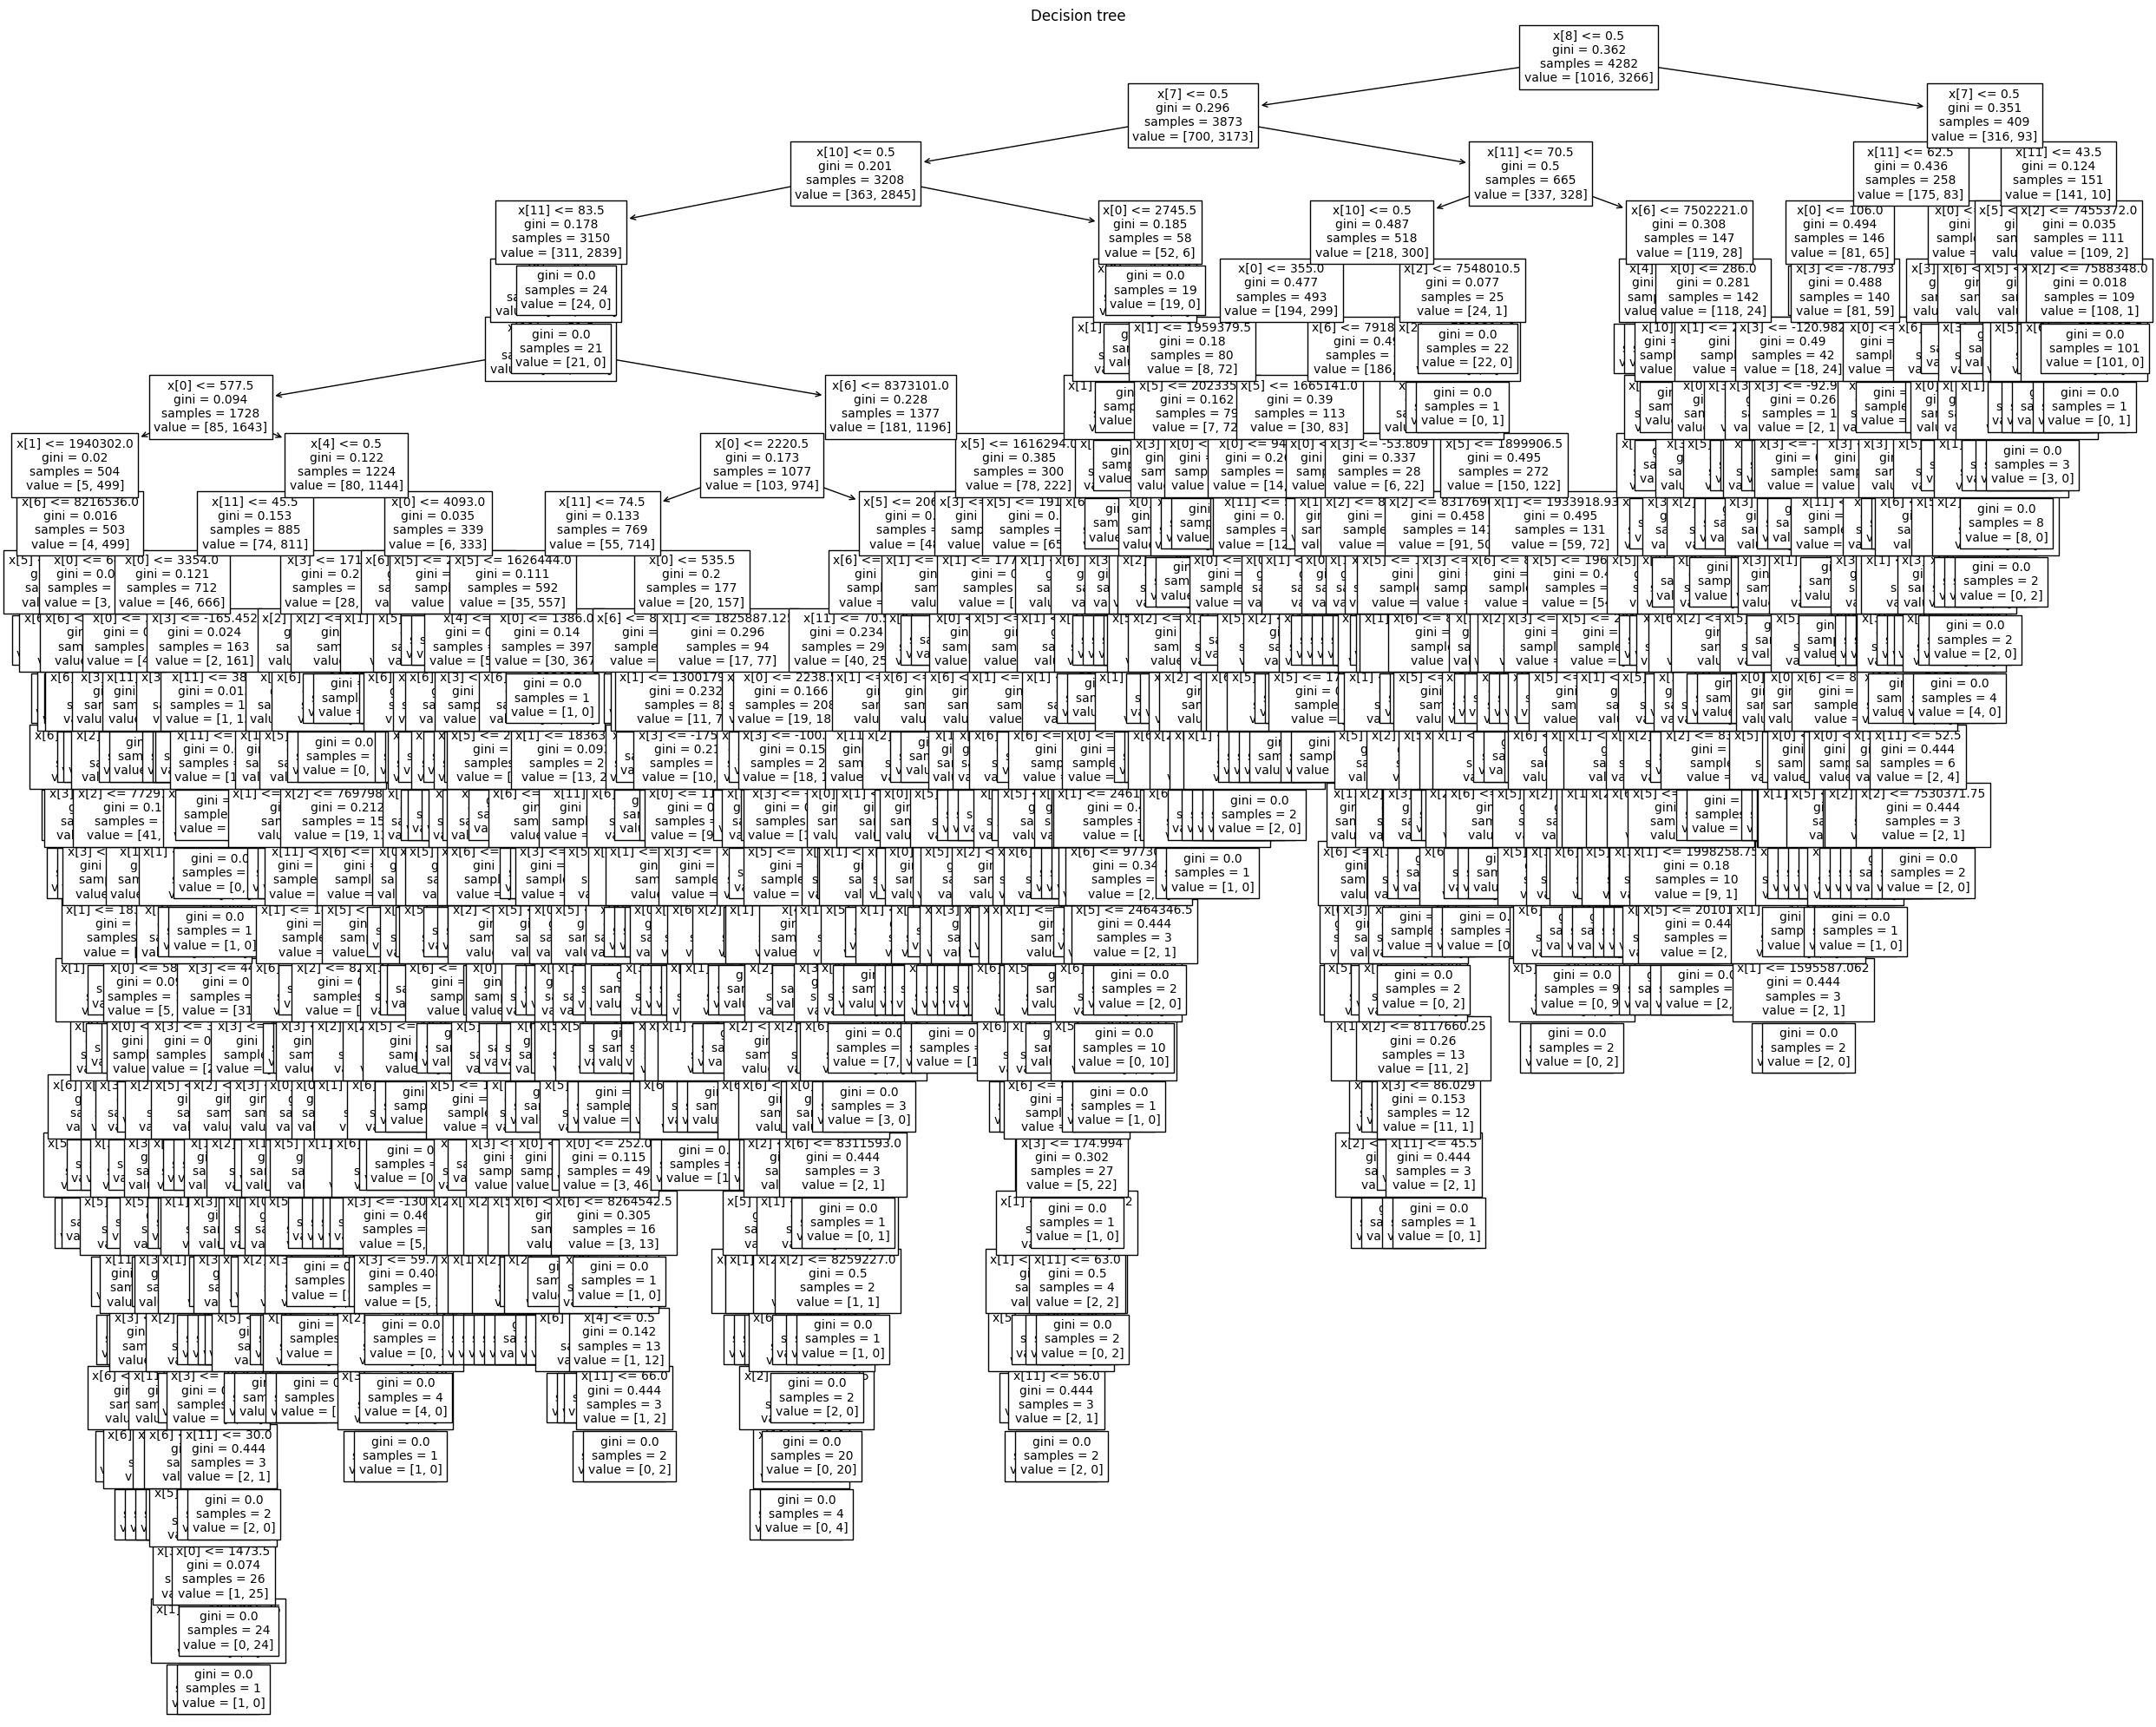

In [6]:
# Plot decision tree
def plot_tree_custom_size(classifier, figsize=(25, 20), fontsize=10):
    fig, ax = plt.subplots(figsize=figsize)
    plot_tree(classifier, fontsize=fontsize, ax=ax)
    ax.set_title("Decision tree")
    fig.tight_layout()

plot_tree_custom_size(decision_tree)

In [7]:
# Performance metrics
y_pred = decision_tree.predict(X_heldout)

def print_performance_metrics(y_true, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred), "\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2}")
    print(f"Recall: {recall_score(y_true, y_pred):.2}")
    print(f"Precision: {precision_score(y_true, y_pred):.2}")
    print(f"F1: {f1_score(y_true, y_pred):.2}")

print_performance_metrics(y_heldout, y_pred)

Confusion Matrix:
 [[222 132]
 [130 944]] 

Accuracy: 0.82
Recall: 0.88
Precision: 0.88
F1: 0.88


Confusion Matrix:
 [[ 158  196]
 [  43 1031]] 

Accuracy: 0.83
Recall: 0.96
Precision: 0.84
F1: 0.9


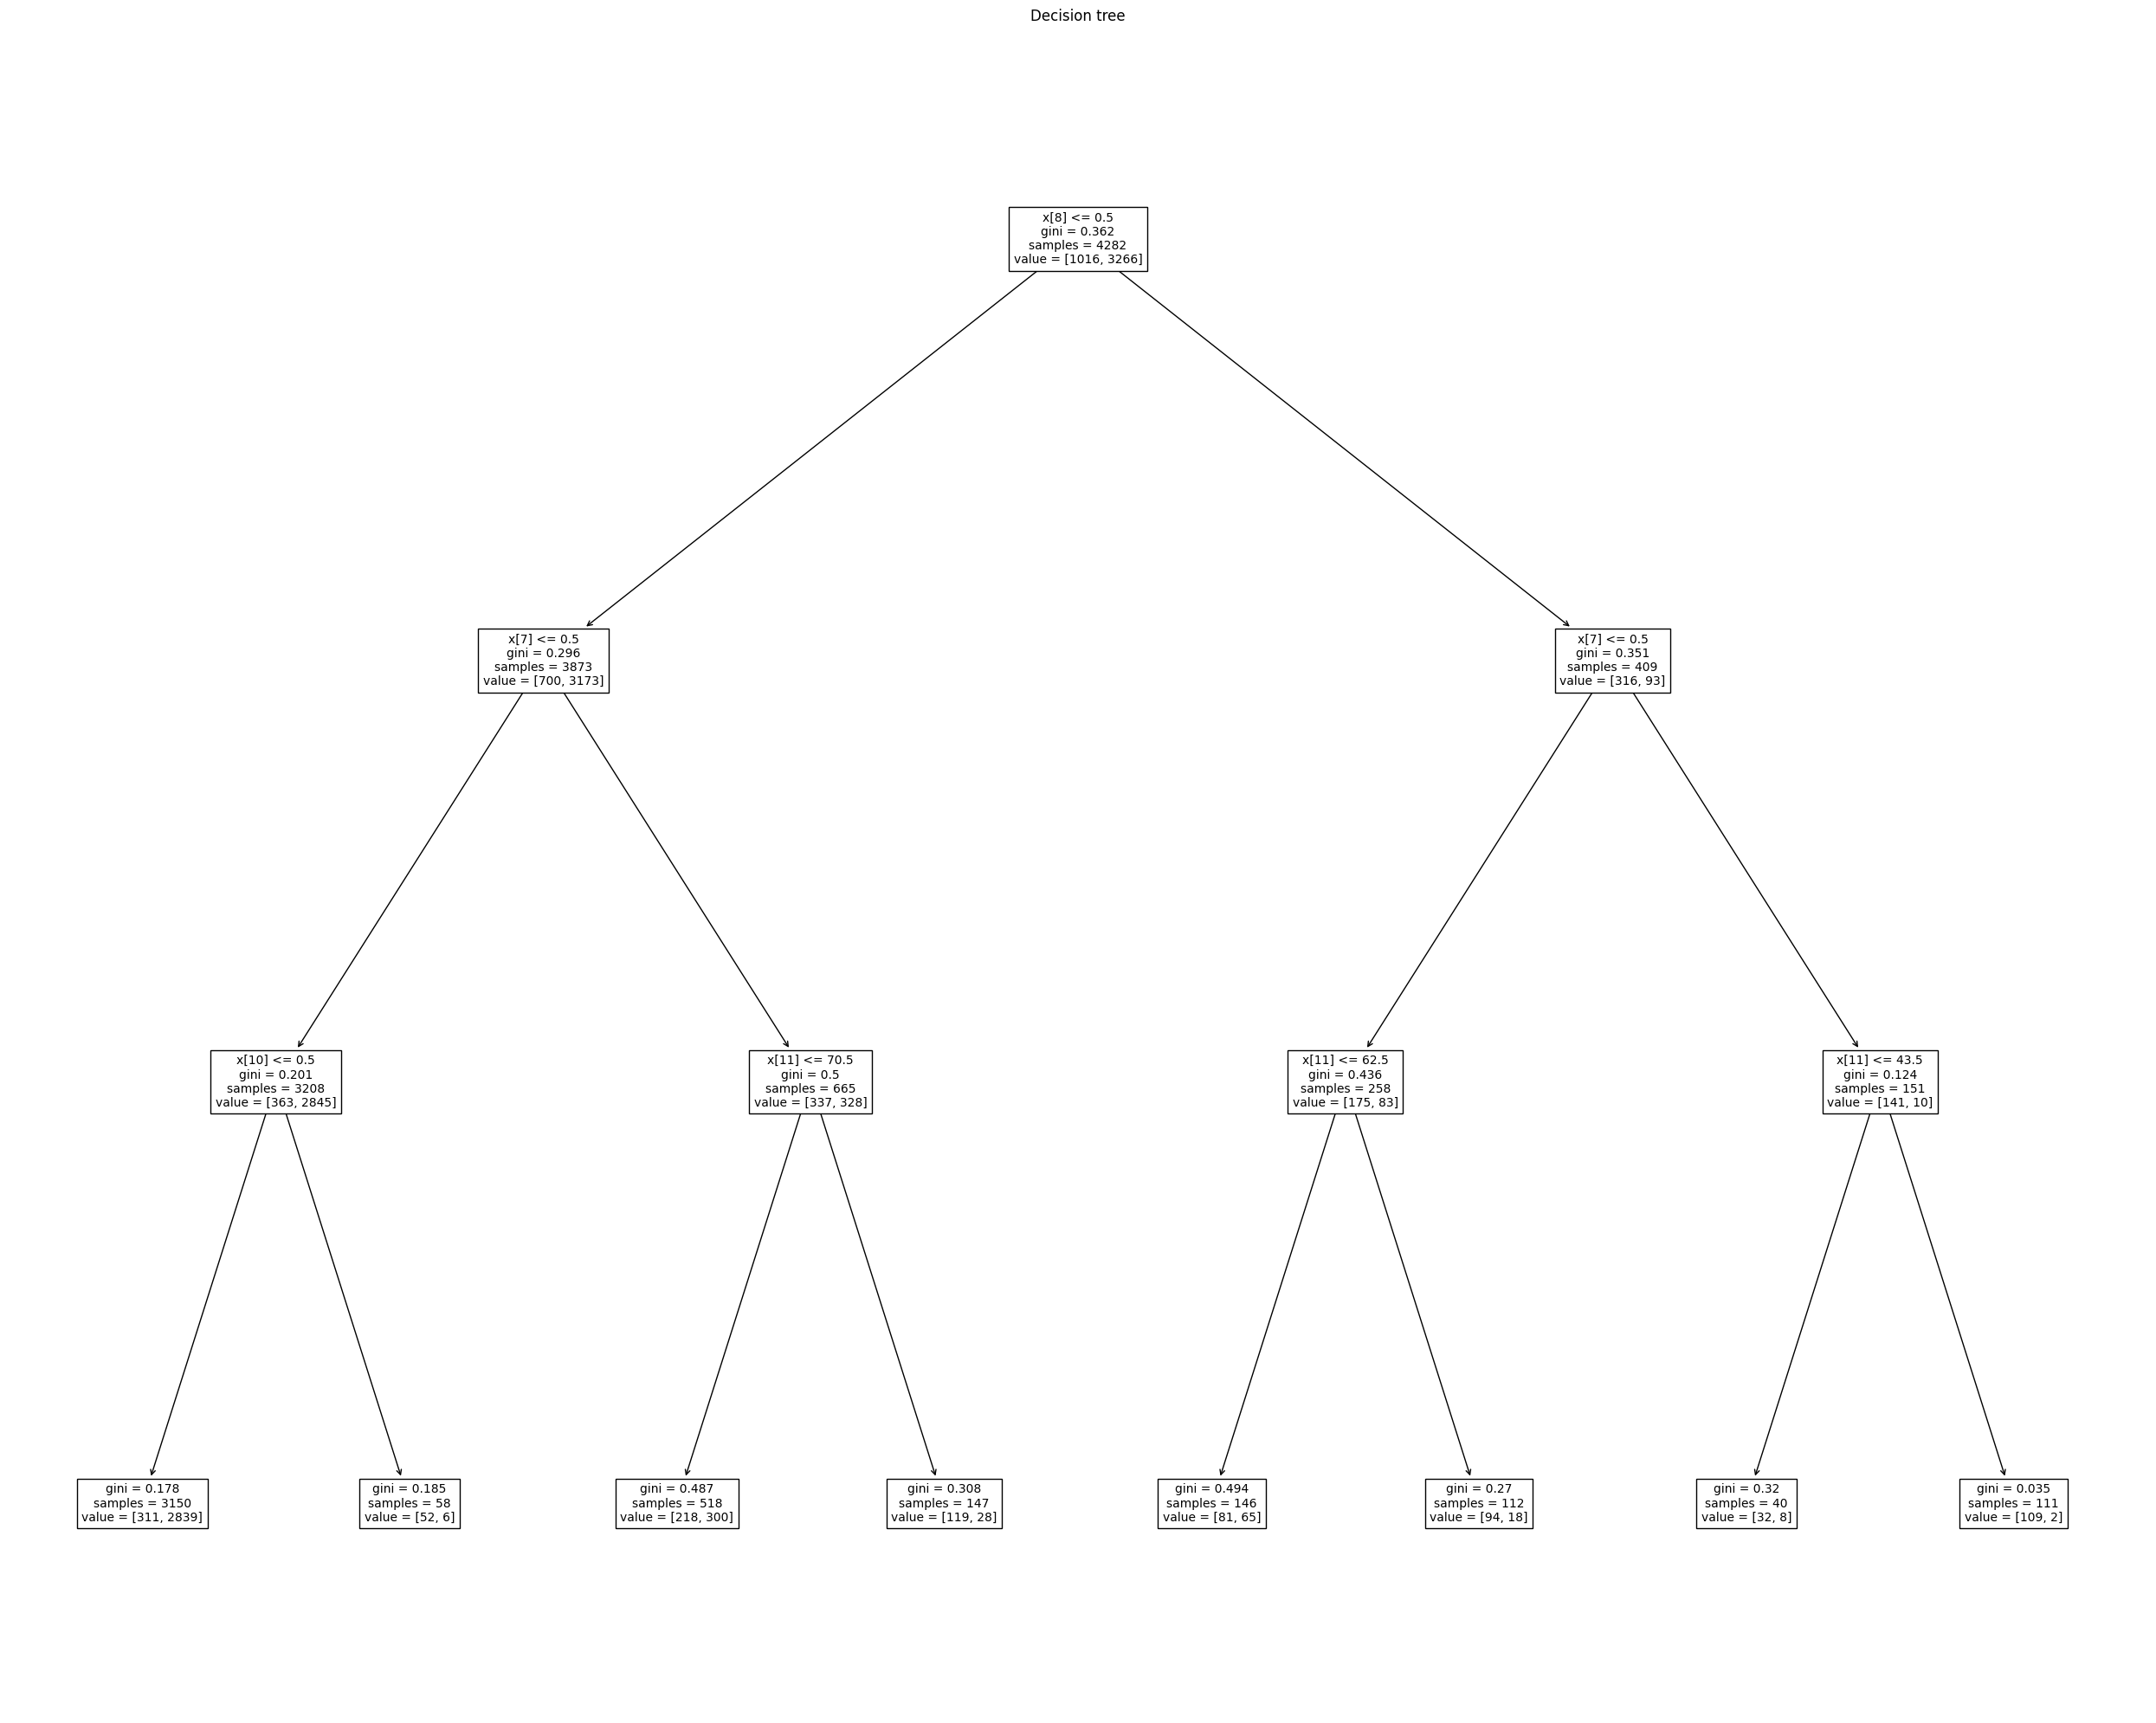

In [8]:
# Trying parameter value max_depth=3

decision_tree_max_dept_3 = tree.DecisionTreeClassifier(max_depth=3)
decision_tree_max_dept_3.fit(X_train, y_train)

y_pred = decision_tree_max_dept_3.predict(X_heldout)
print_performance_metrics(y_heldout, y_pred)

plot_tree_custom_size(decision_tree_max_dept_3)


In [11]:
# Parameter tuning
# Choice of parameters: max_depth, min_samples_leaf
# Using 5-fold cross-validation in order to decide the optimal values of the parameters max_depth and min_samples_leaf.

# Create 5-fold cross-validation
nk = 5
kf = KFold(n_splits=nk, random_state=RANDOM_SEED, shuffle=True)

# Search space of the parameters
max_depth_choices = np.arange(2, 10)
min_samples_leaf_choices = np.arange(1, 14) ** 2

# Learn an optimal decision tree model

param_choices = [
    {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}
    for max_depth in max_depth_choices
    for min_samples_leaf in min_samples_leaf_choices
]

accuracy = np.zeros((nk, len(param_choices)))
f1 = np.zeros((nk, len(param_choices)))
recall = np.zeros((nk, len(param_choices)))
precision = np.zeros((nk, len(param_choices)))

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    for j, param in enumerate(param_choices):
        dt = tree.DecisionTreeClassifier(
            max_depth=param["max_depth"], min_samples_leaf=param["min_samples_leaf"]
        )
        dt.fit(X_t, y_t)
        y_pred = dt.predict(X_val)
        accuracy[i][j] = accuracy_score(y_val, y_pred)
        f1[i][j] = f1_score(y_val, y_pred)
        recall[i][j] = recall_score(y_val, y_pred)
        precision[i][j] = precision_score(y_val, y_pred)

# Finding model with maximum F1 score
best_model = param_choices[np.argmax(np.mean(f1, axis=0))]
print("Selected model for F1:", best_model)

# Computing the performance of the best model 
dt = tree.DecisionTreeClassifier(**best_model)
dt.fit(X_t, y_t)
y_pred = dt.predict(X_heldout)
print_performance_metrics(y_heldout, y_pred)

Selected model for F1: {'max_depth': 9, 'min_samples_leaf': 16}
Confusion Matrix:
 [[ 211  143]
 [  73 1001]] 

Accuracy: 0.85
Recall: 0.93
Precision: 0.88
F1: 0.9


In [12]:
#Random forest - combines the simplicity of decision trees with flexibility resulting in a vast improvement in accuracy

rf_baseline = RandomForestClassifier(random_state=RANDOM_SEED)
rf_baseline.fit(X_train, np.ravel(y_train))
rf_baseline_pred = rf_baseline.predict(X_heldout)

print_performance_metrics(y_heldout, rf_baseline_pred)

Confusion Matrix:
 [[ 230  124]
 [  60 1014]] 

Accuracy: 0.87
Recall: 0.94
Precision: 0.89
F1: 0.92


In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Parameter tuning
# Choice of parameters: N_estimator, max_features
# Using 5-fold cross-validation in order to decide the optimal values of the parameters N_estimator and max_features.

# Create 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

# Search space of the parameters
param_choices = [
    {'max_features':max_f, 'n_estimators':num_est}
    for max_f in np.arange(2,11,4)
    for num_est in np.arange (20,141,60)
]

accuracy = np.zeros((k, len(param_choices)))
f1 = np.zeros((k, len(param_choices)))
recall = np.zeros((k, len(param_choices)))
precision = np.zeros((k, len(param_choices)))


# Learn an optimal Random Forest model
def train_and_evaluate(classifier, train_index, val_index, param):
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    rf = classifier(**param, random_state=RANDOM_SEED)
    rf.fit(X_t, np.ravel(y_t))
    y_pred = rf.predict(X_val)

    return {
        "accuracy": accuracy_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
    }

def parallel_k_fold_cross_validation(classifier, param_choices):
    with ThreadPoolExecutor() as executor:
        future_to_params = {
            executor.submit(
                train_and_evaluate, classifier, train_index, val_index, param
            ): (i, j)
            for i, (train_index, val_index) in enumerate(kf.split(X_train))
            for j, param in enumerate(param_choices)
        }

        for future in as_completed(future_to_params):
            i, j = future_to_params[future]
            result = future.result()
            accuracy[i][j] = result["accuracy"]
            f1[i][j] = result["f1"]
            recall[i][j] = result["recall"]
            precision[i][j] = result["precision"]
    return {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}


results = parallel_k_fold_cross_validation(RandomForestClassifier, param_choices)
f1 = results["f1"]

# Finding model with maximum F1 score

def select_best_model(measure, results):
    mean_results = np.mean(results, axis=0)
    best_model_index = np.argmax(mean_results)
    return best_model_index

best_model_index = select_best_model("F1", f1)
best_model_params = param_choices[best_model_index]
print("Selected model for F1:", best_model_params)

# Computing the performance of the best model 
best_rf = RandomForestClassifier(
    max_features=best_model_params["max_features"],
    n_estimators=best_model_params["n_estimators"],
    random_state=RANDOM_SEED,
)
best_rf.fit(X_train, np.ravel(y_train))
y_best_rf_pred = best_rf.predict(X_heldout)

print_performance_metrics(y_heldout, y_best_rf_pred)


Selected model for F1: {'max_features': 2, 'n_estimators': 80}
Confusion Matrix:
 [[ 228  126]
 [  56 1018]] 

Accuracy: 0.87
Recall: 0.95
Precision: 0.89
F1: 0.92
